In [9]:
import torch
import torch.nn as nn
import numpy as np
from torchviz import make_dot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# download https://graphviz.org/download/ untuk membentuk visual

xl = pd.ExcelFile("Data Ta Idol musim 1-12 fixed with label.xlsx")
xl.sheet_names

['Sheet1']

In [10]:
df = xl.parse("Sheet1")
df.head()

,No,Nama Peserta,Lagu & Penyanyi Asli,Hasil,Genre,Babak,Musim,Usia,Gender,Asal Daerah
0,1,Helena Andrian,"Yang Ku 'Tunggu"" - Anggun",1,1,8,1,20,0,1
1,2,Raymond Latuheru,"""Firasat"" - Marcell Siahaan",0,1,8,1,22,1,1
2,3,Tiara Degrasia,"""Kissing A Fool"" - George Michael",0,2,8,1,20,0,3
3,4,Aldy Erlangga,"""One Last Cry"" - Brian McKnight",0,3,8,1,22,1,1
4,5,Imelda Ragillia,"""Cinta Kita"" - Reza Artamevia",0,1,8,1,22,0,1


In [11]:
# Normalisasi Umur dan babak
scaler = MinMaxScaler(feature_range=(0, 1))
df['Usia_Normalized'] = scaler.fit_transform(df[['Usia']])
df['Babak_Normalized'] = scaler.fit_transform(df[['Babak']])
df.head()

,No,Nama Peserta,Lagu & Penyanyi Asli,Hasil,Genre,Babak,Musim,Usia,Gender,Asal Daerah,Usia_Normalized,Babak_Normalized
0,1,Helena Andrian,"Yang Ku 'Tunggu"" - Anggun",1,1,8,1,20,0,1,0.285714,0.294118
1,2,Raymond Latuheru,"""Firasat"" - Marcell Siahaan",0,1,8,1,22,1,1,0.428571,0.294118
2,3,Tiara Degrasia,"""Kissing A Fool"" - George Michael",0,2,8,1,20,0,3,0.285714,0.294118
3,4,Aldy Erlangga,"""One Last Cry"" - Brian McKnight",0,3,8,1,22,1,1,0.428571,0.294118
4,5,Imelda Ragillia,"""Cinta Kita"" - Reza Artamevia",0,1,8,1,22,0,1,0.428571,0.294118


In [12]:
## Pisahkan fitur dan target
X = df[['Genre','Babak','Gender','Asal Daerah','Usia_Normalized','Babak_Normalized']]
y = df['Hasil']

# Bagi data menjadi training dan testing set 70 % untuk training dan 30% untuk testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Create a simple neural network with a sigmoid activation function
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
# Adjust output_size based on the number of possible 'hasil' values (0,1) meaka output_size = 2, sedangkan input_size tergantung terhadap parameter inputan
# dalam hal ini masih menggunakan 1 field [gendre] yang memiliki jumlah 1
model = NeuralNetwork(input_size=6, output_size=2)  

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Bagian untuk training
# Train the model num_epoch  bertujuan untuk melakukan iterasi terhadap model sehingga mendapatkan accuration yang optimal
num_epochs = 400
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Bagian untuk melakukan testing terhadap model dengan output berupa akurasi
# Test the model
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    print(f'Accuracy: {torch.sum(predicted == y_test).item() / float(y_test.size(0)) * 100}%')

Accuracy: 82.89473684210526%


## Membuat visualisasi terkait node dan layer

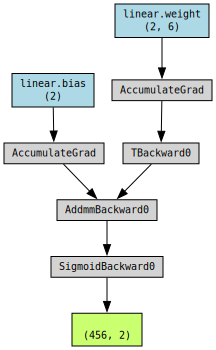

In [13]:
# Forward pass to compute the output
output = model(X_test)

# Generate a visualization of the computational graph
graph = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization and display it
# graph.render("neural_network_graph", format="png")  # Saves as 'neural_network_graph.png'
graph

Penjelasan Komponen
linear.weight (2, 6):

Ini adalah matriks bobot dari lapisan linear dengan ukuran (2, 6).
Ukuran (2, 6) berarti layer memiliki 6 input features (kolom pada data input) dan 2 output neurons.
linear.bias (2):

Ini adalah vektor bias dengan ukuran (2), sesuai dengan jumlah output neurons.
Operasi di Graf:

TBackward0: Operasi transposisi untuk menghitung gradien pada backward pass.
AddmmBackward0: Operasi matrix multiplication (add + matrix multiply) untuk forward pass di lapisan linear.
SigmoidBackward0: Operasi backward untuk fungsi aktivasi sigmoid.
Output `(456, 2):

Ukuran output terakhir adalah (456, 2), yang berarti terdapat 456 sampel dalam batch, masing-masing dengan 2 output (sesuai dengan jumlah neuron di layer output).
Arti Graf Secara Keseluruhan
Forward Pass: Input data (456, 6) (456 sampel dengan 6 fitur) melalui layer Linear:


Hasil ini kemudian diteruskan ke fungsi aktivasi sigmoid.

Backward Pass: Selama backward propagation, graf ini menunjukkan aliran gradien melalui layer (linear.weight, linear.bias) dan fungsi sigmoid untuk memperbarui parameter dengan metode optimasi.

## fungsi save model

In [14]:
# Define a function to save the model
def save_model(model, filename):
  """Saves the PyTorch model to a file.

  Args:
    model: The PyTorch model to save.
    filename: The filename to save the model to.
  """
  torch.save(model.state_dict(), filename)  # Save model state dictionary

# Train the model
# ... (your training loop remains the same)

# Save the model after training
model_filename = "indonesia_idol.pt"  # Replace with your desired filename
save_model(model, model_filename)

print(f"Model saved to {model_filename}")


Model saved to indonesia_idol.pt


## Memasukan data kedalam model yang sudah disimpan

### load sample data baru

In [21]:
# load new data
sampleNewData = pd.ExcelFile("sample new data.xlsx")
sampleNewData.sheet_names
newData = sampleNewData.parse("Sheet1")
newData.head()

,No,Nama Peserta,Lagu & Penyanyi Asli,Hasil,Genre,Babak,Musim,Usia,Gender,Asal Daerah
0,1,Helena Andrian,"Yang Ku 'Tunggu"" - Anggun",1,1,8,1,20,0,1


### melakukan prediction menggunakan model yang sudah di load terhadap data baru dan hasil predictionnya dimasukan kedalam sample data baru

In [24]:
model = NeuralNetwork(input_size=6, output_size=2)
model.load_state_dict(torch.load("indonesia_idol.pt"))
model.eval()  # Set the model to evaluation mode

# Prepare new data
scaler = MinMaxScaler(feature_range=(0, 1))
newData['Usia_Normalized'] = scaler.fit_transform(newData[['Usia']])
newData['Babak_Normalized'] = scaler.fit_transform(newData[['Babak']])
new_data = torch.tensor(newData[['Genre','Babak','Gender','Asal Daerah','Usia_Normalized','Babak_Normalized']].values, dtype=torch.float32)  # Adjust values as needed

# Make predictions
with torch.no_grad():
  predictions = model(new_data)
  _, predicted_classes = torch.max(predictions.data, 1)
  print("prediction result ", predicted_classes.tolist())

new_data_pred = pd.DataFrame(predicted_classes).replace(-1, np.nan)

new_data_pred = new_data_pred.stack().reset_index(level=1, drop=True).to_frame('Hasil').reset_index()

newData = newData.merge(new_data_pred)
newData = newData.drop('index', axis=1)
column_order = newData.columns.tolist()
column_order.append(column_order.pop(column_order.index('Hasil')))
newData = newData[column_order]

newData.head()


prediction result  [1]


C:\Users\ebdesk\AppData\Local\Temp\ipykernel_38636\2114796165.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("indonesia_idol.pt"))


,No,Nama Peserta,Lagu & Penyanyi Asli,Genre,Babak,Musim,Usia,Gender,Asal Daerah,Usia_Normalized,Babak_Normalized,Hasil
0,1,Helena Andrian,"Yang Ku 'Tunggu"" - Anggun",1,8,1,20,0,1,0.0,0.0,1
